In [1]:

import numpy as np
import pandas as pd
import pyvista

from subsurface.core.geological_formats import Collars, Survey, BoreholeSet
from subsurface.core.geological_formats.boreholes._combine_trajectories import MergeOptions
from subsurface.core.reader_helpers.readers_data import GenericReaderFilesHelper
from subsurface.core.structs.base_structures.base_structures_enum import SpecialCellCase
from subsurface.modules.reader.wells.read_borehole_interface import read_collar, read_survey, read_lith
import subsurface as ss
from subsurface.modules.visualization import to_pyvista_points, pv_plot, to_pyvista_line, init_plotter

# Importing GemPy
import gempy as gp

Setting Backend To: AvailableBackends.numpy


In [2]:
import pandas as pd

# Constants
SCALE = 10000
INPUT_FILE = "resources/boreholes_with_elevation.csv"
OUTPUT_FILE = "resources/boreholes_with_elevation_scaled.csv"

# Load CSV
df = pd.read_csv(INPUT_FILE)

# Normalize Latitude and Longitude
df["Scaled_Latitude"] = (df["Latitude"] - df["Latitude"].mean()) * SCALE
df["Scaled_Longitude"] = (df["Longitude"] - df["Longitude"].mean()) * SCALE

# Save to new CSV
df.to_csv(OUTPUT_FILE, index=False)

print(f"Saved scaled data to {OUTPUT_FILE}")

Saved scaled data to resources/boreholes_with_elevation_scaled.csv


In [3]:
raw_borehole_data_csv = "resources/boreholes_with_elevation_scaled.csv"

collar_df: pd.DataFrame = read_collar(
    GenericReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        index_col="Borehole ID",
        usecols=['Scaled_Latitude', 'Scaled_Longitude', 'Elevation', "Borehole ID"],
        columns_map={
            "Borehole ID": "id",  # ? Index name is not mapped
            "Scaled_Latitude": "y",
            "Scaled_Longitude": "x",
            "Elevation": "z"
        }
    )
)

# Convert to UnstructuredData
unstruc: ss.UnstructuredData = ss.UnstructuredData.from_array(
    vertex=collar_df[["x", "y", "z"]].values,
    cells=SpecialCellCase.POINTS
)

points = ss.PointSet(data=unstruc)
collars: Collars = Collars(
    ids=collar_df.index.to_list(),
    collar_loc=points
)

/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/subsurface/modules/reader/wells/_read_to_df.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  d = reader(


In [4]:
import pyvista as pv
import numpy as np

# Scale factor to make x/y more visible
SCALE = 1

# Scale coordinates around their mean
scaled_x = (collar_df["x"] - collar_df["x"].mean()) * SCALE
scaled_y = (collar_df["y"] - collar_df["y"].mean()) * SCALE
z = collar_df["z"]

# Combine into a single array of points
points = np.column_stack((scaled_x, scaled_y, z))

# Create a PyVista point cloud
point_cloud = pv.PolyData(points)

# Plot
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, color="deepskyblue", point_size=20, render_points_as_spheres=True)
plotter.view_xy()
plotter.reset_camera()
plotter.show_bounds()
plotter.show()


Widget(value='<iframe src="http://localhost:56648/index.html?ui=P_0x144bfa450_0&reconnect=auto" class="pyvista…

In [5]:
survey_df: pd.DataFrame = read_survey(
    GenericReaderFilesHelper(
        file_or_buffer="resources/boreholes_with_elevation.csv",
        index_col="Borehole ID",
        usecols=["Borehole ID", "md"]
    )
)

survey: Survey = Survey.from_df(survey_df)

survey

/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/subsurface/modules/reader/wells/_read_to_df.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  d = reader(
/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/subsurface/modules/reader/wells/read_borehole_interface.py:82: UserWarning: inc and/or azi columns are not present in the file. The boreholes will be straight.
  warnings.warn(


Survey(ids=array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148

Read the collar data from the CSV

In [6]:
lith = read_lith(
    GenericReaderFilesHelper(
        file_or_buffer="resources/boreholes_with_elevation.csv",
        usecols=['Borehole ID', 'Top Depth', 'Bottom Depth', 'Lithology'],
        columns_map={
            'Top Depth': 'top',
            'Bottom Depth': 'base',
            'Lithology': 'component lith',
        }
    )
)

# Update survey data with lithology information
survey.update_survey_with_lith(lith)

lith

/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/subsurface/modules/reader/wells/_read_to_df.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  d = reader(


('cell',) are not coordinates with an index xarray dataset must include 'cell' key (KeyError) or xarray 'cell' has no index (ValueError).


,top,base,component lith,lith_ids
Borehole ID,,,,
1,0.0,1.2,Fill,0
1,1.2,2.7,Sandy silt,1
1,2.7,8.0,Silt,2
2,0.0,0.8,Topsoil / vegetation,3
2,0.8,2.5,Silty sand,4
...,...,...,...,...
198,10.0,11.0,Silty sand,4
199,0.0,2.5,Silty sand,4
199,2.5,11.0,Silt,2


Creating a Borehole Set and Visualizing in 3D

In [7]:
# Combine collar and survey into a BoreholeSet
borehole_set = BoreholeSet(
    collars=collars,
    survey=survey,
    merge_option=MergeOptions.INTERSECT
)

In [8]:
import matplotlib.pyplot as plt

well_mesh = to_pyvista_line(
    line_set=borehole_set.combined_trajectory,
    active_scalar="lith_ids",
    radius=40
)

p = init_plotter()

# Set colormap for lithologies
boring_cmap = plt.get_cmap(name="viridis", lut=14)
p.add_mesh(well_mesh, cmap=boring_cmap)

collar_mesh = to_pyvista_points(collars.collar_loc)

p.add_mesh(collar_mesh, render_points_as_spheres=True)
p.add_point_labels(
    points=collars.collar_loc.points,
    labels=collars.ids,
    point_size=10,
    shape_opacity=0.5,
    font_size=12,
    bold=True
)


p.show()

Widget(value='<iframe src="http://localhost:56648/index.html?ui=P_0x16be41cd0_1&reconnect=auto" class="pyvista…

In [9]:
import pandas as pd

df = pd.read_csv(INPUT_FILE)

materials = df["Lithology"].unique()

print(df["Lithology"].unique())

colors_generator = gp.data.ColorsGenerator()

elements_dict = {
    name.lower().replace(" ", "_").replace("/", "_"): {
        "id": idx,
        "color": next(colors_generator)
    }
    for idx, name in enumerate(materials)
}

elements = gp.structural_elements_from_borehole_set(
    borehole_set=borehole_set,
    elements_dict=elements_dict
)


['Fill' 'Sandy silt' 'Silt' 'Topsoil / vegetation' 'Silty sand' 'Clay'
 'Silty clay' 'Clayey silt' 'Clayey sand' 'Sand' 'Undefined' 'Gravel'
 'Gravelly sand' 'Asphalt / concrete' 'Peat' 'Sandy gravel']


In [10]:
import gempy_viewer as gpv

# Create a structural group with the elements
group = gp.data.StructuralGroup(
    name="Stratigraphic Pile",
    elements=elements,
    structural_relation=gp.data.StackRelationType.ERODE
)

# Define the structural frame
structural_frame = gp.data.StructuralFrame(
    structural_groups=[group],
    color_gen=colors_generator
)

In [11]:
all_surface_points_coords: gp.data.SurfacePointsTable = structural_frame.surface_points_copy
extent_from_data = all_surface_points_coords.xyz.min(axis=0), all_surface_points_coords.xyz.max(axis=0)
# Initialize GeoModel
geo_model = gp.data.GeoModel(
    name="Stratigraphic Pile",
    structural_frame=structural_frame,
    grid=gp.data.Grid(
        extent=[extent_from_data[0][0], extent_from_data[1][0], extent_from_data[0][1], extent_from_data[1][1], extent_from_data[0][2], extent_from_data[1][2]],
        resolution=(50, 50, 50)
    ),
    interpolation_options=gp.data.InterpolationOptions(
        range=5,
        c_o=10,
        mesh_extraction=True,
        number_octree_levels=3,
    ),
)

In [12]:
gempy_plot = gpv.plot_3d(
    model=geo_model,
    kwargs_pyvista_bounds={
            'show_xlabels': False,
            'show_ylabels': False,
    },
    show=True,
    image=False
)

2025-03-31 21:48:46.448 Python[3786:151758] +[IMKClient subclass]: chose IMKClient_Legacy
2025-03-31 21:48:46.449 Python[3786:151758] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


Adding Boreholes and Collars to the Visualization

In [13]:
sp_mesh: pyvista.PolyData = gempy_plot.surface_points_mesh

pyvista_plotter = init_plotter()
pyvista_plotter.show_bounds(all_edges=True)

# Set limits for the units to visualize
units_limit = [0, 13]
pyvista_plotter.add_mesh(
    well_mesh.threshold(units_limit),
    cmap="tab20c",
    clim=units_limit
)

# Add collar points
pyvista_plotter.add_mesh(
    collar_mesh,
    point_size=10,
    render_points_as_spheres=True
)

# Label the collars with their names
pyvista_plotter.add_point_labels(
    points=collars.collar_loc.points,
    labels=collars.ids,
    point_size=10,
    shape_opacity=0.5,
    font_size=12,
    bold=True
)
# Add surface points from the geological model
pyvista_plotter.add_actor(gempy_plot.surface_points_actor)

# Show the final 3D plot
pyvista_plotter.show()

Widget(value='<iframe src="http://localhost:56648/index.html?ui=P_0x1744b8b90_2&reconnect=auto" class="pyvista…

Adding Surfaces and Formations

/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


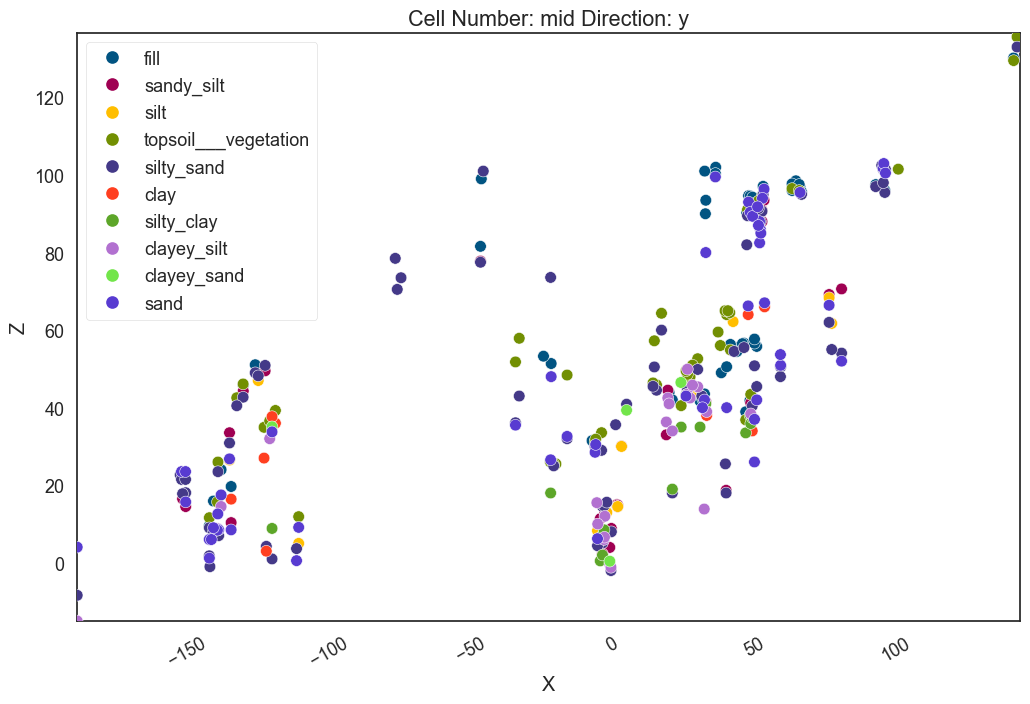

In [14]:
group = gp.data.StructuralGroup(
    name="Stratigraphic Pile Top",
    elements=elements[:10],
    structural_relation=gp.data.StackRelationType.ERODE
)
geo_model.structural_frame.structural_groups[0] = group


# Visualize the surfaces in 2D

g2d = gpv.plot_2d(geo_model)

Model Computation

In [16]:
import gempy as gp
gp.add_orientations(
    x=[300000],
    y=[3930000],
    z=[0],
    elements_names=[elements[0].name],  # wrap in list
    pole_vector=np.array([[0, 0, 1]]),  # wrap in 2D array
    geo_model=geo_model
)

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Stratigraphic Pile Top,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=fill,
	color=#015482,
	is_active=True
),
Element(
	name=sandy_silt,
	color=#9f0052,
	is_active=True
),
Element(
	name=silt,
	color=#ffbe00,
	is_active=True
),
Element(
	name=topsoil___vegetation,
	color=#728f02,
	is_active=True
),
Element(
	name=silty_sand,
	color=#443988,
	is_active=True
),
Element(
	name=clay,
	color=#ff3f20,
	is_active=True
),
Element(
	name=silty_clay,
	color=#5DA629,
	is_active=True
),
Element(
	name=clayey_silt,
	color=#b271d0,
	is_active=True
),
Element(
	name=clayey_sand,
	color=#72e54a,
	is_active=True
),
Element(
	name=sand,
	color=#583bd1,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [17]:
geo_model.interpolation_options

InterpolationOptions(kernel_options={'range': 5, 'c_o': 10, 'uni_degree': 1, 'i_res': 4, 'gi_res': 2, 'number_dimensions': 3, 'kernel_function': <AvailableKernelFunctions.cubic: KernelFunction(base_function=<function cubic_function at 0x1447ed760>, derivative_div_r=<function cubic_function_p_div_r at 0x1447ed800>, second_derivative=<function cubic_function_a at 0x1447ed8a0>, consume_sq_distance=False)>, 'kernel_solver': <Solvers.DEFAULT: 1>, 'compute_condition_number': False, 'optimizing_condition_number': False, 'condition_number': None}, evaluation_options={'_number_octree_levels': 3, '_number_octree_levels_surface': 4, 'octree_curvature_threshold': -1, 'octree_error_threshold': 1.0, 'octree_min_level': 2, 'mesh_extraction': True, 'mesh_extraction_masking_options': <MeshExtractionMaskingOptions.INTERSECT: 3>, 'mesh_extraction_fancy': True, 'evaluation_chunk_size': 500000, 'compute_scalar_gradient': False, 'verbose': False}, temp_interpolation_values=<gempy_engine.core.data.options.temp_interpolation_values.TempInterpolationValues object at 0x32155a8d0>, debug=True, cache_mode=CacheMode.IN_MEMORY_CACHE, cache_model_name=Stratigraphic Pile, block_solutions_type=BlockSolutionType.DENSE_GRID, sigmoid_slope=50000, debug_water_tight=False)

In [18]:
gp.compute_model(geo_model)

Setting Backend To: AvailableBackends.numpy
Chunking done: 94 chunks
Chunking done: 46 chunks


Solutions(3 Octree Levels, 10 DualContouringMeshes)

In [42]:
import pickle
import os

# Make sure the directory exists
os.makedirs("resources", exist_ok=True)

# Save the model
with open("resources/borehole_model.pkl", "wb") as f:
    pickle.dump(geo_model, f)

print("✅ Model saved to borehole_model.pkl")


✅ Model saved to borehole_model.pkl


/Users/anatolykuznetsov/PycharmProjects/GemPy model/.venv/lib/python3.11/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


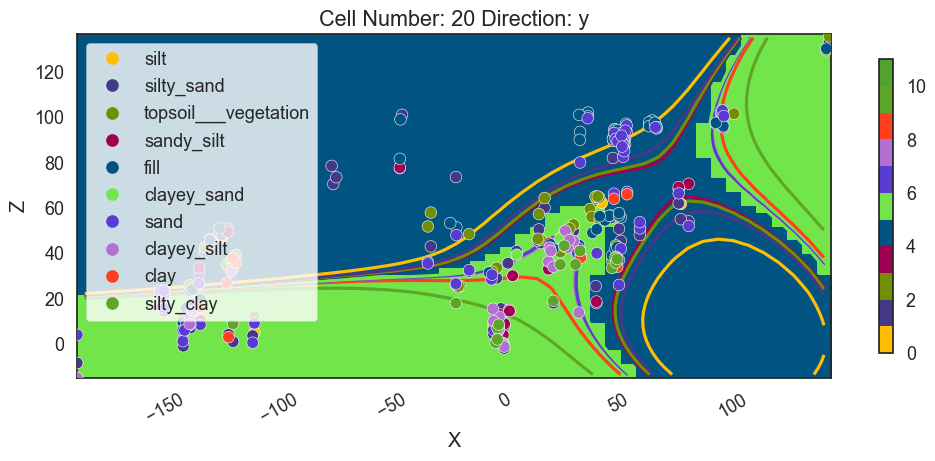

In [20]:
gpv.plot_2d(geo_model, cell_number=20)

In [43]:
import gempy_viewer as gpv

# Step 5: Visualization
plotter = pv.Plotter()
gp.plot_3d(geo_model, plotter=plotter, plotter_type='pyvista')

# Add borehole points to the plot
borehole_points = pv.PolyData(surface_points[["X", "Y", "Z"]].values)
plotter.add_mesh(borehole_points, color="red", point_size=10, render_points_as_spheres=True)

plotter.show()

Save 3D plot

In [44]:
well_mesh.save("resources/g3d.vtk")

In [45]:
import pyvista as pv

# Load individual mesh
loaded_mesh = pv.read("resources/g3d.vtk")

# Display it
plotter = pv.Plotter()
plotter.add_mesh(loaded_mesh)
plotter.show()

Widget(value='<iframe src="http://localhost:50357/index.html?ui=P_0x3541d7c90_8&reconnect=auto" class="pyvista…

In [4]:
import gempy as gp
import gempy_viewer as gpv
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.notebook = True
pv.start_xvfb()

# Display the result in 3d
gpv.plot_3d(geo_model, show_lith=True, show_boundaries=True, ve=None, image=True)

OSError: Please install Xvfb with:

Debian
$ sudo apt install libgl1-mesa-glx xvfb

CentOS / RHL
$ sudo yum install libgl1-mesa-glx xvfb



In [6]:
# Install required packages
!sudo apt install libgl1-mesa-glx xvfb

!pip install gempy_viewer
!pip install pyvista

Password:
sudo: a password is required

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
